In [136]:
import cv2
import pandas as pd
import datasets
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os
from PIL import Image, ImageFile
import numba
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm
import re

%matplotlib inline

In [135]:
!pip install transformers
!pip install datasets
!pip install bertviz
!pip install umap-learn
!pip install accelerate

In [134]:
!pip install datasets

In [4]:
df_text_test = pd.read_csv('df_text_test.csv')
df_text_train = pd.read_csv('df_text_train.csv')
df_text_validation = pd.read_csv('df_text_validation.csv')

## Посмотрим количество представителей классов в датасете на примере трейна

In [ ]:
classes = {np.int64(0): 'sadness',
 np.int64(1): 'joy',
 np.int64(4): 'fear',
 np.int64(3): 'anger',
 np.int64(5): 'surprise',
 np.int64(2): 'neutral',
 np.int64(6): 'disgust'}



 tok_to_ind = {0: 'sadness',
 1: 'anger',
 2: 'neutral',
 'fear': 3,
 'content': 4,
 'happy': 5,
 'disgust': 6,
 'surprise': 7}

df_text_test["label_name"] = df_text_test["label"].apply(lambda x: classes[x])
df_text_train["label_name"] = df_text_train["label"].apply(lambda x: classes[x])
df_text_validation["label_name"] = df_text_validation["label"].apply(lambda x: classes[x])

<Axes: ylabel='label_name'>

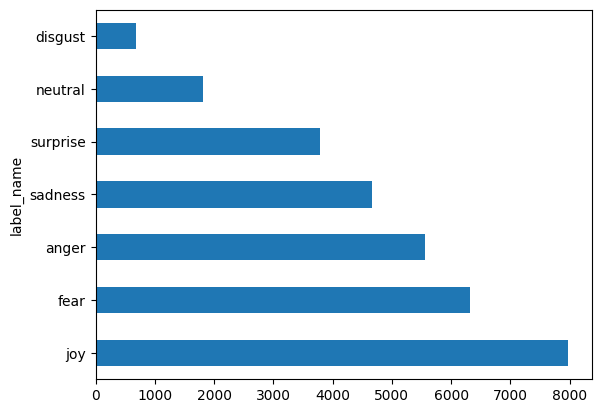

In [ ]:
label_counts = df_text_train["label_name"].value_counts()
label_counts.plot.barh()

## Посмотрим распределение по длинам текстов в зависимости от класса

<Axes: title={'center': 'words_per_post'}, xlabel='label_name'>

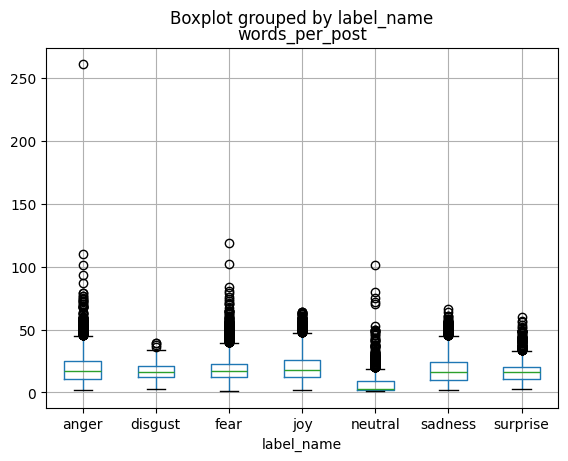

In [ ]:
df_text_train["words_per_post"] = df_text_train["text"].str.split().apply(len)
df_text_train.boxplot("words_per_post", by="label_name")

## Словари для перехода от имени лэйбла к его номеру и наоборот


In [6]:
unique_values = df_text_test['label'].unique()
unique_values_ = df_text_test['label_name'].unique()

class_to_name = dict(zip(unique_values, unique_values_))

name_to_class = {}
for key in class_to_name:
    name_to_class[class_to_name[key]] = key

[0 1 4 3 5 2 6] ['sadness' 'joy' 'fear' 'anger' 'surprise' 'neutral' 'disgust']


{np.int64(0): 'sadness',
 np.int64(1): 'joy',
 np.int64(4): 'fear',
 np.int64(3): 'anger',
 np.int64(5): 'surprise',
 np.int64(2): 'neutral',
 np.int64(6): 'disgust'}

In [5]:
def GetTextsDataset():
    """ Формирует из PandasDataframe - DatasetDict """

    df_text_train = pd.read_csv('df_text_train.csv')
    df_text_train = df_text_train.drop(columns=['label_name'])

    df_text_validation = pd.read_csv('df_text_validation.csv')
    df_text_validation = df_text_validation.drop(columns=['label_name'])

    df_text_test = pd.read_csv('df_text_test.csv')
    df_text_test = df_text_test.drop(columns=['label_name'])

    train_dataset = datasets.Dataset.from_dict(df_text_train)
    validation_dataset = datasets.Dataset.from_dict(df_text_validation)
    test_dataset = datasets.Dataset.from_dict(df_text_test)

    my_dataset_dict = datasets.DatasetDict({"train":train_dataset, "validation":validation_dataset, "test":test_dataset})
    print(my_dataset_dict)
    return my_dataset_dict

In [ ]:
#rm -r /content/disilbert-finetuned-emotion

##Text

## Тюн текстовой модели

In [82]:
from transformers import AutoTokenizer

#model_text_ckpt =  "disilbert-finetuned-emotion/checkpoint-882"
model_text_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_text_ckpt)
tokenizer.vocab_size, tokenizer.model_max_length

(30522, 512)

In [83]:
def tokenize(batch):
    temp = tokenizer(batch["text"], padding=True, truncation=True)
    return temp

emotion_text = GetTextsDataset()
emotions_encoded = emotion_text.map(tokenize, batched=True, batch_size=None)

print(tokenize(emotion_text["train"][:1]))

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'label'],
        num_rows: 30807
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'text', 'label'],
        num_rows: 12305
    })
    test: Dataset({
        features: ['Unnamed: 0', 'text', 'label'],
        num_rows: 5535
    })
})


Map:   0%|          | 0/30807 [00:00<?, ? examples/s]

Map:   0%|          | 0/12305 [00:00<?, ? examples/s]

Map:   0%|          | 0/5535 [00:00<?, ? examples/s]

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1]]}


In [84]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_imdb = emotion_text.map(preprocess_function, batched=True)

Map:   0%|          | 0/30807 [00:00<?, ? examples/s]

Map:   0%|          | 0/12305 [00:00<?, ? examples/s]

Map:   0%|          | 0/5535 [00:00<?, ? examples/s]

In [85]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [86]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(model_text_ckpt, num_labels=7)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [87]:
batch_size = 64
model_name = "disilbert-finetuned-emotion2"

training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=6,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False)

from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy" : acc, "f1" : f1}


trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)

trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning:

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead

<ipython-input-87-74f3c7166000>:24: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: stickycherry0 (stickycherry0-inp) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.541501,0.805689,0.788816
2,0.711000,0.391791,0.864689,0.861598
3,0.322300,0.264887,0.916619,0.916233
4,0.236000,0.185536,0.946445,0.946267
5,0.174200,0.141388,0.960585,0.960343
6,0.128900,0.125051,0.965461,0.965403


TrainOutput(global_step=2892, training_loss=0.28651599303650493, metrics={'train_runtime': 4443.7943, 'train_samples_per_second': 41.596, 'train_steps_per_second': 0.651, 'total_flos': 1.3248240345197172e+16, 'train_loss': 0.28651599303650493, 'epoch': 6.0})

## Push to Hugginface

In [89]:
from huggingface_hub import notebook_login
notebook_login()

In [90]:
model.push_to_hub('VK26/disilbert-finetuned-emotion2')

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/VK26/disilbert-finetuned-emotion2/commit/3e388716e102ce6e282d05dc7d41a3f8fbd0691f', commit_message='Upload DistilBertForSequenceClassification', commit_description='', oid='3e388716e102ce6e282d05dc7d41a3f8fbd0691f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/VK26/disilbert-finetuned-emotion2', endpoint='https://huggingface.co', repo_type='model', repo_id='VK26/disilbert-finetuned-emotion2'), pr_revision=None, pr_num=None)

## Пробую достать модельку с Hugginface

In [93]:
from transformers import pipeline
pipe = pipeline("text-classification", model="VK26/disilbert-finetuned-emotion2")
pipe(df_text_test["text"][6])

Device set to use cuda:0


[{'label': 'LABEL_3', 'score': 0.9981306195259094}]

In [104]:
def FromBoxModelInference(prompt):
        preds = pipe(prompt)
        preds = sorted(preds, key=lambda item: item["score"], reverse=True)
        class_number = int(preds[0]["label"][-1])
        return class_to_name[class_number], class_number,  preds[0]['score']

In [105]:
FromBoxModelInference(df_text_test["text"][6])

('anger', 3, 0.9981306195259094)

In [106]:
import torch

def TextInference(prompt):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenized_prompt = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs_txt = model.forward(**tokenized_prompt)

    logits = outputs_txt["logits"]

    probs = torch.nn.Softmax(dim=1)

    predicted_class = torch.argmax(logits).item()

    return class_to_name[predicted_class], predicted_class

def InferenceFails():
    heat_map = np.zeros((7, 7))
    for ind, row in tqdm(df_text_test.iterrows(), ncols=80, ascii=True, desc='Total'):
        prediction = FromBoxModelInference(row["text"])[1]
        true = row["label"]

        heat_map[prediction][true] += 1

    fig1 = go.Figure(data=go.Heatmap(
                   z=heat_map / heat_map.sum(axis=0),
                   text=heat_map,
                   texttemplate="%{text}",
                   textfont={"size":20},
                   x=list(class_to_name.values()),
                   y=list(class_to_name.values()),
                   hoverongaps = False))

    fig2 = go.Figure(data=go.Heatmap(
                   z=heat_map / heat_map.sum(axis=0),
                   text=np.round(heat_map / heat_map.sum(axis=0), decimals=2),
                   texttemplate="%{text}",
                   textfont={"size":20},
                   x=list(class_to_name.values()),
                   y=list(class_to_name.values()),
                   hoverongaps = False))
    fig1.show()
    fig2.show()

    return heat_map

a = InferenceFails()

Total: 0it [00:00, ?it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Total: 5535it [00:30, 183.41it/s]


## Text experiments

In [107]:
!pip install nltk
!pip install wordcloud

In [108]:
import nltk
from nltk import word_tokenize, Text
from nltk.probability import FreqDist
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt_tab')

def MostPopularWords(dataset=True):
    cnt = {}
    for ind, row in tqdm(df_text_test.iterrows(), ncols=80, ascii=True, desc='Total'):
        text = row["text"]
        label = row["label"] if dataset else FromBoxModelInference(row["text"])[1] #TextInference(text)[1]

        if not label in list(cnt.keys()):
            cnt[label] = []

        text = re.sub(r'[^\w\s]', '', text).strip().lower()
        text = text.split()
        cnt[label] += text

    _stopwords = stopwords.words("english")
    for label in cnt:
        _string = " ".join(cnt[label])
        text_tokens = word_tokenize(_string)
        text_tokens = [token.strip() for token in text_tokens if token not in _stopwords]
        cnt[label] = {}
        cnt[label]["text"] = nltk.Text(text_tokens)
        cnt[label]["freq"] = FreqDist(cnt[label]["text"])

    return cnt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [110]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize, Text
from nltk.probability import FreqDist
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt_tab')

def MostPopularWords(dataset=True):
    cnt = {}
    for ind, row in tqdm(df_text_test.iterrows(), ncols=80, ascii=True, desc='Total'):
        text = row["text"]
        label = row["label"] if dataset else FromBoxModelInference(row["text"])[1] #TextInference(text)[1]

        if not label in list(cnt.keys()):
            cnt[label] = []

        text = re.sub(r'[^\w\s]', '', text).strip().lower()
        text = text.split()
        cnt[label] += text

    _stopwords = stopwords.words("english")
    for label in cnt:
        _string = " ".join(cnt[label])
        text_tokens = word_tokenize(_string)
        text_tokens = [token.strip() for token in text_tokens if token not in _stopwords]
        cnt[label] = {}
        cnt[label]["text"] = nltk.Text(text_tokens)
        cnt[label]["freq"] = FreqDist(cnt[label]["text"])

    return cnt

def DrowFreqHisto(cnt):
    counter = 7
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    points = {"0" : {0 : 0}, "1" : {0 : 1}, "2" : {1 : 0}, "3" : {1 : 1}, "4" : {1 : 2}, "5" : {2 : 1}, "6" : {2 : 2}}
    for i in range(7):
        words_freqs = cnt[i]["freq"]
        words_freqs = sorted(words_freqs.items(), key=lambda item: item[1], reverse=True)
        words, freqs = zip(*(words_freqs[:counter]))
        axs[list(points[str(i)].keys())[0], list(points[str(i)].values())[0]].set_title(class_to_name[i])
        axs[list(points[str(i)].keys())[0], list(points[str(i)].values())[0]].barh(words, freqs)




def DrowWordCloud(cnt):
    counter = 7
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    points = {"0" : {0 : 0}, "1" : {0 : 1}, "2" : {1 : 0}, "3" : {1 : 1}, "4" : {1 : 2}, "5" : {2 : 1}, "6" : {2 : 2}}
    for i in range(7):
        text = cnt[i]["text"]
        text_raw = " ".join(text)
        wordcloud = WordCloud(width=1600, height=800).generate(text_raw)
        axs[list(points[str(i)].keys())[0], list(points[str(i)].values())[0]].set_title(class_to_name[i])
        axs[list(points[str(i)].keys())[0], list(points[str(i)].values())[0]].imshow(wordcloud)



Total: 5535it [00:00, 14160.51it/s]


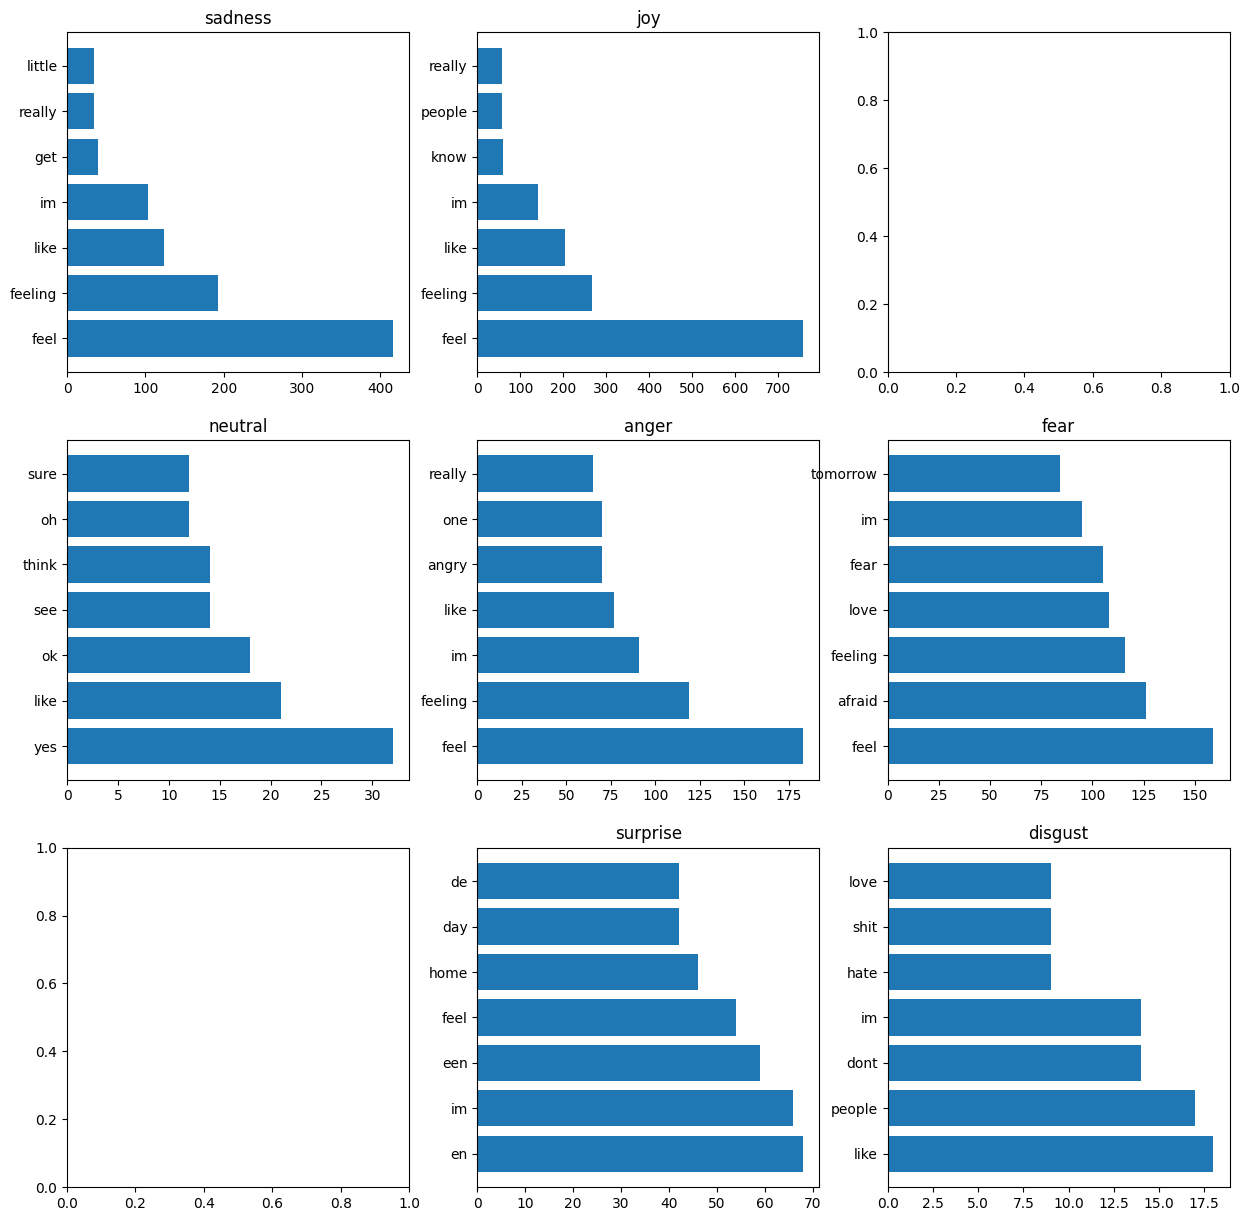

In [111]:
count_words_by_categories = MostPopularWords(dataset=True)

DrowFreqHisto(count_words_by_categories)

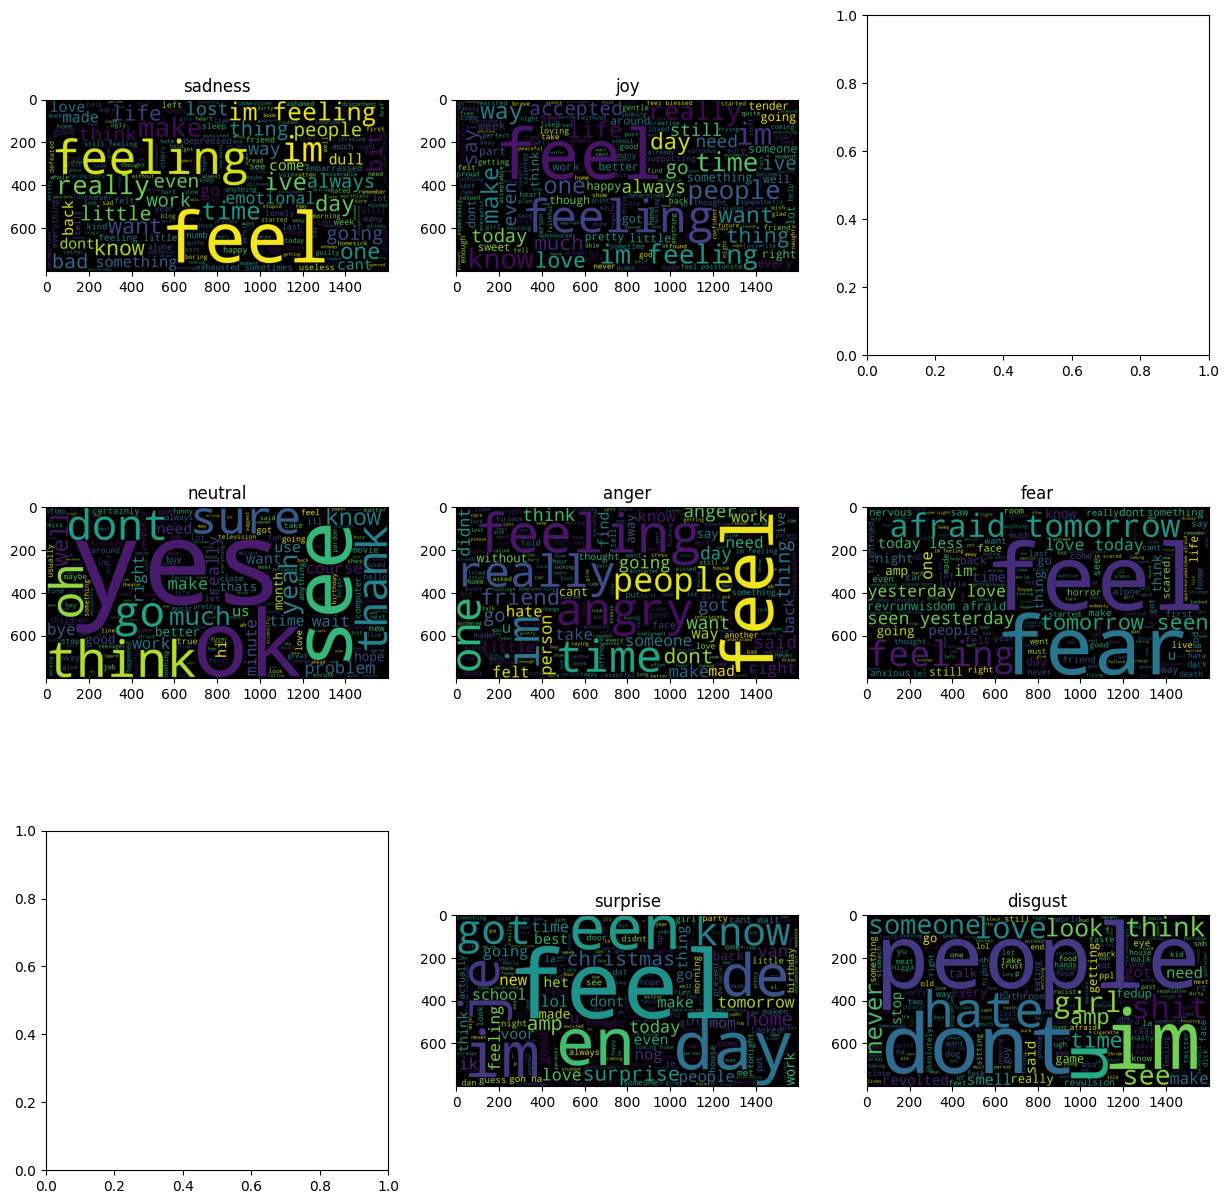

In [112]:
DrowWordCloud(count_words_by_categories)

Total: 5535it [00:30, 181.16it/s]


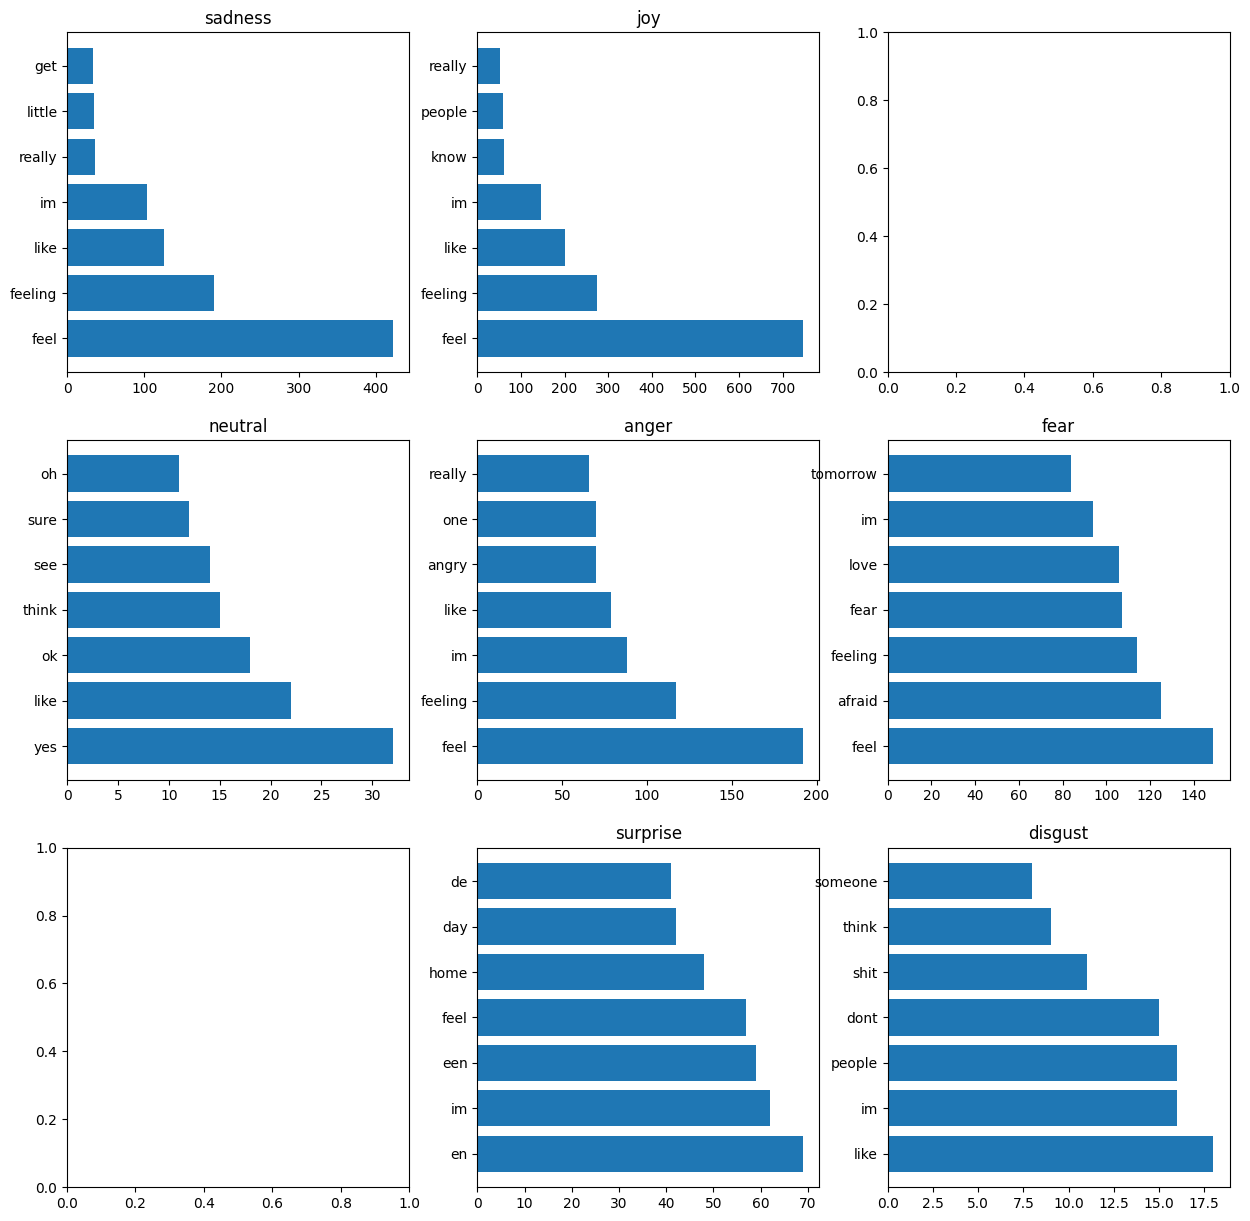

In [113]:
count_words_by_categories_inf = MostPopularWords(dataset=False)

DrowFreqHisto(count_words_by_categories_inf)

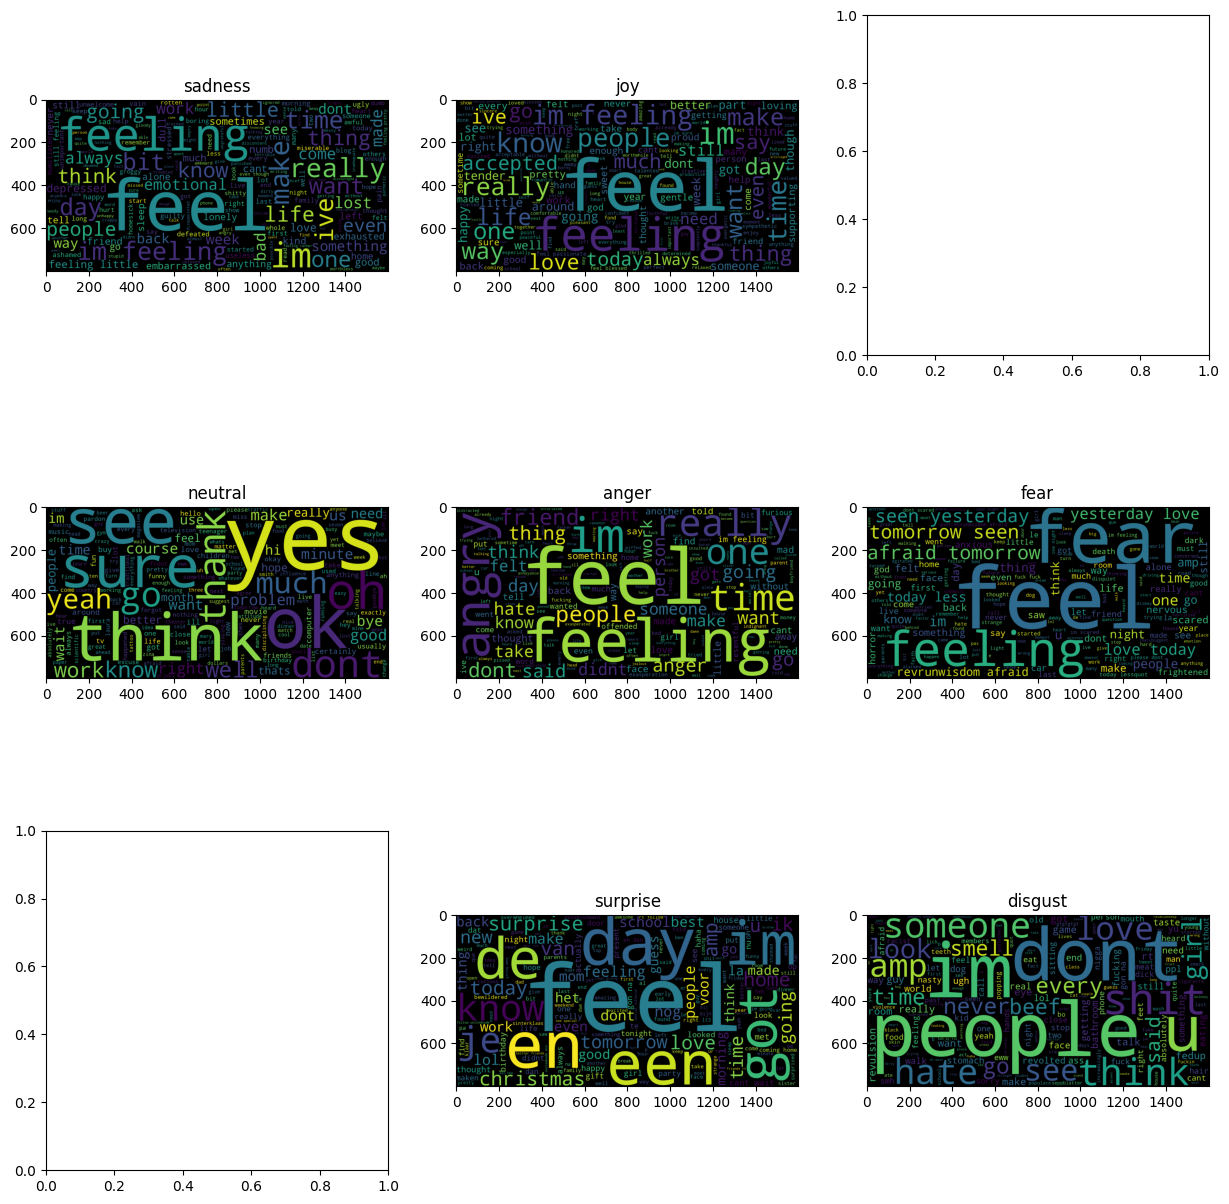

In [114]:
DrowWordCloud(count_words_by_categories_inf)

In [119]:
def FromBoxModelInference(prompt):
        prompt = prompt.split()
        for i in range(len(prompt), -1):
            if prompt[i] in ["feel", "feeling", "en", "de", "im", "een"]:
                prompt.pop(i)

        prompt = "".join(prompt)
        preds = pipe(prompt)
        preds = sorted(preds, key=lambda item: item["score"], reverse=True)

        class_number = int(preds[0]["label"][-1])
        return class_to_name[class_number], class_number,  preds[0]['score']


def InferenceFails():
    heat_map = np.zeros((7, 7))
    for ind, row in tqdm(df_text_test.iterrows(), ncols=80, ascii=True, desc='Total'):
        prediction = FromBoxModelInference(row["text"])[1]
        true = row["label"]

        heat_map[prediction][true] += 1

    fig1 = go.Figure(data=go.Heatmap(
                   z=heat_map / heat_map.sum(axis=0),
                   text=heat_map,
                   texttemplate="%{text}",
                   textfont={"size":20},
                   x=list(class_to_name.values()),
                   y=list(class_to_name.values()),
                   hoverongaps = False))

    fig2 = go.Figure(data=go.Heatmap(
                   z=heat_map / heat_map.sum(axis=0),
                   text=np.round(heat_map / heat_map.sum(axis=0), decimals=2),
                   texttemplate="%{text}",
                   textfont={"size":20},
                   x=list(class_to_name.values()),
                   y=list(class_to_name.values()),
                   hoverongaps = False))
    fig1.show()
    fig2.show()

    return heat_map

a = InferenceFails()

Total: 5535it [00:31, 175.74it/s]


In [ ]:
def FromBoxModelInferenceImg(img):
        preds = pipevit(img)
        print(preds)
        class_ = preds[0]["label"]
        return class_, tok_to_ind[class_],  preds[0]['score']

##Imgaes

## Tune ViT

In [9]:
from datasets import load_dataset

ds = load_dataset("tukey/human_face_emotions_roboflow")
ds = ds.filter(lambda example, indice: example['qa'][0]["answer"] != "content", with_indices=True)



README.md:   0%|          | 0.00/387 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/371M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9400 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9400 [00:00<?, ? examples/s]

In [14]:
ds_split_train_test = ds["train"].train_test_split(test_size=0.15)
train_ds, eval_ds = ds_split_train_test["train"], ds_split_train_test["test"]

ds_split_train_test = train_ds.train_test_split(test_size=0.15)
train_ds, test_ds = ds_split_train_test["train"], ds_split_train_test["test"]

In [15]:
train_ds

Dataset({
    features: ['image', 'qa'],
    num_rows: 5964
})

In [17]:
eval_ds

Dataset({
    features: ['image', 'qa'],
    num_rows: 1239
})

In [16]:
test_ds

Dataset({
    features: ['image', 'qa'],
    num_rows: 1053
})

In [18]:
import torch

from transformers import ViTImageProcessor
from transformers import AutoModel


model_picture_ckpt = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_picture_ckpt)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
processor

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'qa'],
        num_rows: 8256
    })
})

In [ ]:
image = ds["train"][0]['image']
processor(image, return_tensors='pt')

{'pixel_values': tensor([[[[ 0.5529,  0.5529,  0.5529,  ...,  0.4431,  0.4510,  0.4431],
          [ 0.5451,  0.5451,  0.5451,  ...,  0.4431,  0.4510,  0.4431],
          [ 0.5373,  0.5373,  0.5373,  ...,  0.4431,  0.4510,  0.4431],
          ...,
          [-0.9137, -0.9059, -0.9137,  ..., -0.9137, -0.8745, -0.8510],
          [-0.9137, -0.9059, -0.9216,  ..., -0.9137, -0.8745, -0.8510],
          [-0.9137, -0.9059, -0.9216,  ..., -0.9137, -0.8745, -0.8510]],

         [[ 0.6157,  0.6157,  0.6157,  ...,  0.5216,  0.5294,  0.5216],
          [ 0.6078,  0.6078,  0.6078,  ...,  0.5216,  0.5294,  0.5216],
          [ 0.6000,  0.6000,  0.6000,  ...,  0.5216,  0.5294,  0.5216],
          ...,
          [-0.9529, -0.9451, -0.9529,  ..., -0.9294, -0.9059, -0.8902],
          [-0.9529, -0.9451, -0.9608,  ..., -0.9216, -0.9059, -0.8902],
          [-0.9529, -0.9451, -0.9608,  ..., -0.9216, -0.9059, -0.8902]],

         [[ 0.1451,  0.1451,  0.1451,  ...,  0.1059,  0.1137,  0.1059],
          [ 0

In [19]:
tok_to_ind = {'sad': 0,
 'anger': 1,
 'neutral': 2,
 'fear': 3,
 'content': 4,
 'happy': 5,
 'disgust': 6,
 'surprise': 7}

In [20]:
def process_example(example):
    inputs = processor(example['image'], return_tensors='pt')
    inputs['labels'] = tok_to_ind[example['qa'][0]["answer"]]
    return inputs

process_example(ds['train'][0])

{'pixel_values': tensor([[[[ 0.5529,  0.5529,  0.5529,  ...,  0.4431,  0.4510,  0.4431],
          [ 0.5451,  0.5451,  0.5451,  ...,  0.4431,  0.4510,  0.4431],
          [ 0.5373,  0.5373,  0.5373,  ...,  0.4431,  0.4510,  0.4431],
          ...,
          [-0.9137, -0.9059, -0.9137,  ..., -0.9137, -0.8745, -0.8510],
          [-0.9137, -0.9059, -0.9216,  ..., -0.9137, -0.8745, -0.8510],
          [-0.9137, -0.9059, -0.9216,  ..., -0.9137, -0.8745, -0.8510]],

         [[ 0.6157,  0.6157,  0.6157,  ...,  0.5216,  0.5294,  0.5216],
          [ 0.6078,  0.6078,  0.6078,  ...,  0.5216,  0.5294,  0.5216],
          [ 0.6000,  0.6000,  0.6000,  ...,  0.5216,  0.5294,  0.5216],
          ...,
          [-0.9529, -0.9451, -0.9529,  ..., -0.9294, -0.9059, -0.8902],
          [-0.9529, -0.9451, -0.9608,  ..., -0.9216, -0.9059, -0.8902],
          [-0.9529, -0.9451, -0.9608,  ..., -0.9216, -0.9059, -0.8902]],

         [[ 0.1451,  0.1451,  0.1451,  ...,  0.1059,  0.1137,  0.1059],
          [ 0

In [21]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = processor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    #print(example_batch['qa'])
    inputs['labels'] = []
    tok = 0
    for qa in example_batch['qa']:
        if 1 < len(qa):
            tok = qa[0][0]["answer"]
        else:
            tok = qa[0]["answer"]

        inputs['labels'].append(tok_to_ind[tok])

    return inputs

In [129]:
tok_to_ind

{'sad': 0,
 'anger': 1,
 'neutral': 2,
 'fear': 3,
 'content': 4,
 'happy': 5,
 'disgust': 6,
 'surprise': 7}

In [23]:
prepared_ds_train = train_ds.with_transform(transform)
prepared_ds_eval = eval_ds.with_transform(transform)
prepared_ds_test = test_ds.with_transform(transform)

In [ ]:
prepared_ds_train[0:2]

{'pixel_values': tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1

In [24]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [25]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)

    return {"accuracy" : acc}

In [26]:
from transformers import ViTForImageClassification

ind_to_tok = {}
for key in tok_to_ind:
    ind_to_tok[tok_to_ind[key]] = key

model = ViTForImageClassification.from_pretrained(
    model_picture_ckpt,
    num_labels=len(tok_to_ind),
    id2label=ind_to_tok,
    label2id=tok_to_ind
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=32,
  evaluation_strategy="steps",
  num_train_epochs=3,
  fp16=False,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [28]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds_train,
    eval_dataset=prepared_ds_test,
    tokenizer=processor,
)

<ipython-input-28-af7ae3c3d6c8>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [29]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,1.186600,1.256971,0.533713
200,0.751900,1.039499,0.624881
300,0.714200,0.946472,0.654321
400,0.373200,0.920718,0.685660
500,0.254000,0.942241,0.685660


***** train metrics *****
  epoch                    =          3.0
  total_flos               = 1291335782GF
  train_loss               =       0.7654
  train_runtime            =   0:14:21.55
  train_samples_per_second =       20.767
  train_steps_per_second   =        0.651


In [30]:
import jax

def process_examplei(example):
    inputs = processor(example['image'], return_tensors='pt')
    return inputs

In [33]:
def InferenseImage(img):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = process_examplei(img).to(device)

    with torch.no_grad():
        outputs = model.forward(**inputs)
    logits = outputs.logits

    probs = torch.nn.Softmax(dim=1)
    predicted_class = torch.argmax(logits).item()

    return ind_to_tok[predicted_class], predicted_class

In [132]:
def FromBoxModelInferenceImg(img):
        preds = pipevit(img)
        print(preds)
        class_ = preds[0]["label"]
        return class_, tok_to_ind[class_],  preds[0]['score']

In [133]:
FromBoxModelInferenceImg(test_ds[1]["image"])

[{'label': 'fear', 'score': 0.8425930738449097}, {'label': 'sad', 'score': 0.08013530820608139}, {'label': 'surprise', 'score': 0.028633221983909607}, {'label': 'disgust', 'score': 0.01699354499578476}, {'label': 'anger', 'score': 0.012649760581552982}]


('fear', 3, 0.8425930738449097)

In [ ]:
from tqdm import trange
mmp = {'sad': 0,
 'anger': 1,
 'neutral': 2,
 'fear': 3,
 'happy': 4,
 'disgust': 5,
 'surprise': 6}
def InferenceFails():
    heat_map = np.zeros((7, 7))
    for i in trange(1053):
        prediction = FromBoxModelInferenceImg(test_ds[i])[1]
        true = tok_to_ind[test_ds[i]['qa'][0]["answer"]]
        if prediction==4 or true==4:
            continue
        if prediction>4:
            prediction -= 1
        if true>4:
            true -= 1
        heat_map[prediction][true] += 1

    fig1 = go.Figure(data=go.Heatmap(
                   z=heat_map / heat_map.sum(axis=0),
                   text=heat_map,
                   texttemplate="%{text}",
                   textfont={"size":20},
                   x=list(mmp.keys()),
                   y=list(mmp.keys()),
                   hoverongaps = False))

    fig2 = go.Figure(data=go.Heatmap(
                   z=heat_map / heat_map.sum(axis=0),
                   text=np.round(heat_map / heat_map.sum(axis=0), decimals=2),
                   texttemplate="%{text}",
                   textfont={"size":20},
                   x=list(mmp.keys()),
                   y=list(mmp.keys()),
                   hoverongaps = False))
    fig1.show()
    fig2.show()
    return heat_map

a = InferenceFails()

In [35]:
from tqdm import trange
mmp = {'sad': 0,
 'anger': 1,
 'neutral': 2,
 'fear': 3,
 'happy': 4,
 'disgust': 5,
 'surprise': 6}
def InferenceFails():
    heat_map = np.zeros((7, 7))
    for i in trange(1053):
        prediction = InferenseImage(test_ds[i])[1]
        true = tok_to_ind[test_ds[i]['qa'][0]["answer"]]
        if prediction==4 or true==4:
            continue
        if prediction>4:
            prediction -= 1
        if true>4:
            true -= 1
        heat_map[prediction][true] += 1

    fig1 = go.Figure(data=go.Heatmap(
                   z=heat_map / heat_map.sum(axis=0),
                   text=heat_map,
                   texttemplate="%{text}",
                   textfont={"size":20},
                   x=list(mmp.keys()),
                   y=list(mmp.keys()),
                   hoverongaps = False))

    fig2 = go.Figure(data=go.Heatmap(
                   z=heat_map / heat_map.sum(axis=0),
                   text=np.round(heat_map / heat_map.sum(axis=0), decimals=2),
                   texttemplate="%{text}",
                   textfont={"size":20},
                   x=list(mmp.keys()),
                   y=list(mmp.keys()),
                   hoverongaps = False))
    fig1.show()
    fig2.show()
    return heat_map

a = InferenceFails()

100%|██████████| 1053/1053 [00:27<00:00, 38.67it/s]


## Push to hugginface

In [38]:
from huggingface_hub import notebook_login
notebook_login()

In [39]:
model.push_to_hub('VK26/ViT-finetuned-emotion')

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/VK26/ViT-finetuned-emotion/commit/9b5540ccec35301b6287ad28e57d0afd04f8a828', commit_message='Upload ViTForImageClassification', commit_description='', oid='9b5540ccec35301b6287ad28e57d0afd04f8a828', pr_url=None, repo_url=RepoUrl('https://huggingface.co/VK26/ViT-finetuned-emotion', endpoint='https://huggingface.co', repo_type='model', repo_id='VK26/ViT-finetuned-emotion'), pr_revision=None, pr_num=None)

## Try to get ViT from Hugginface

In [120]:
# test mymodel


from transformers import pipeline
pipevit = pipeline("image-classification", model="VK26/ViT-finetuned-emotion")
pipevit(test_ds[1]["image"])

Device set to use cuda:0


[{'label': 'fear', 'score': 0.8425930738449097},
 {'label': 'sad', 'score': 0.08013530820608139},
 {'label': 'surprise', 'score': 0.028633221983909607},
 {'label': 'disgust', 'score': 0.01699354499578476},
 {'label': 'anger', 'score': 0.012649760581552982}]

In [52]:
pipe(test_ds[1]["image"])

[{'label': 'fear', 'score': 0.8425930738449097},
 {'label': 'sad', 'score': 0.08013530820608139},
 {'label': 'surprise', 'score': 0.028633221983909607},
 {'label': 'disgust', 'score': 0.01699354499578476},
 {'label': 'anger', 'score': 0.012649760581552982}]